# GRAPE calculation of control fields for cnot implementation

Robert Johansson (robert@riken.jp)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
from qutip import *
from qutip.control import *

In [3]:
T = 2 * np.pi 
times = np.linspace(0, T, 500)

In [4]:
from qutip.qip.operations import cnot

U = cnot()
R = 500
H_ops = [tensor(sigmax(), identity(2)),
         tensor(sigmay(), identity(2)),
         tensor(sigmaz(), identity(2)),
         tensor(identity(2), sigmax()),
         tensor(identity(2), sigmay()),
         tensor(identity(2), sigmaz()),
         tensor(sigmax(), sigmax()) +
         tensor(sigmay(), sigmay()) +
         tensor(sigmaz(), sigmaz())]

H_labels = [r'$u_{1x}$', r'$u_{1y}$', r'$u_{1z}$',
            r'$u_{2x}$', r'$u_{1y}$', r'$u_{2z}$',
            r'$u_{xx}$',
            r'$u_{yy}$',
            r'$u_{zz}$',
        ]

In [5]:
H0 = 0 * np.pi * (tensor(sigmax(), identity(2)) + tensor(identity(2), sigmax()))

c_ops = []

# This is the analytical result in the absense of single-qubit tunnelling
#g = pi/(4 * T)
#H = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))

# GRAPE

In [6]:
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary_adaptive, cy_grape_unitary

In [7]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [8]:
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

u_limits = None #[0, 1 * 2 * pi]
alpha = None

In [9]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi*1, alpha=alpha, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:  26.39s. Est. time left: 00:00:03:57
20.0%. Run time:  52.49s. Est. time left: 00:00:03:29
30.0%. Run time:  78.89s. Est. time left: 00:00:03:04
40.0%. Run time: 104.90s. Est. time left: 00:00:02:37
50.0%. Run time: 131.08s. Est. time left: 00:00:02:11
60.0%. Run time: 157.78s. Est. time left: 00:00:01:45
70.0%. Run time: 184.21s. Est. time left: 00:00:01:18
80.0%. Run time: 209.92s. Est. time left: 00:00:00:52
90.0%. Run time: 235.56s. Est. time left: 00:00:00:26
Total run time: 260.77s


## Plot control fields for cnot gate in the presense of single-qubit tunnelling

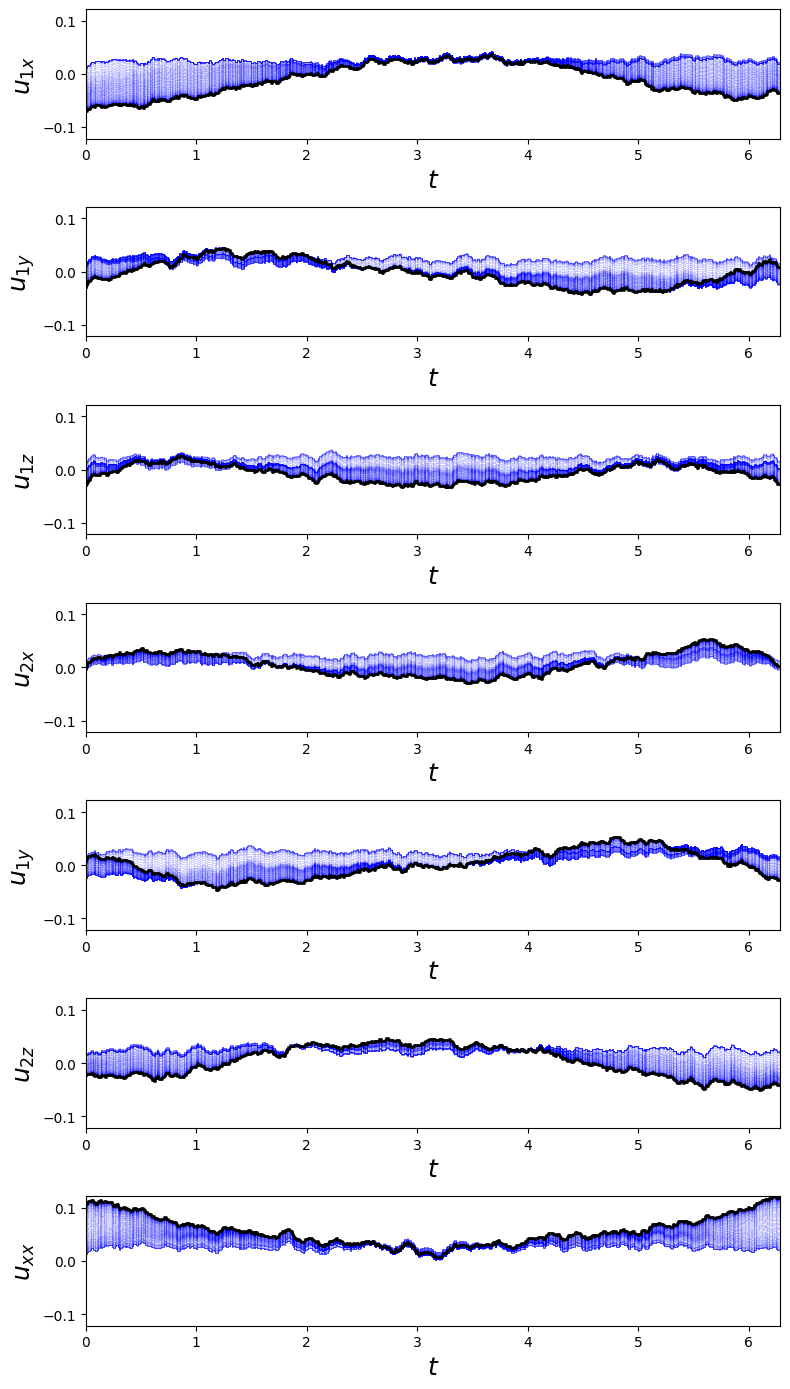

In [10]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);

## Fidelity/overlap

In [11]:
U

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [12]:
result.U_f

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[-7.07106781e-01-7.07106781e-01j -1.42109313e-16-2.42045905e-16j
   5.04843495e-16+1.18349561e-16j  1.25474054e-16+2.53088844e-16j]
 [-8.72406911e-17-1.31256037e-16j -7.07106781e-01-7.07106781e-01j
  -8.41340886e-16+1.35677060e-15j -6.54056819e-16-1.58222451e-15j]
 [ 4.37624795e-16+6.41798730e-16j -2.74217769e-15+8.88094563e-16j
  -2.22695126e-16+8.74517472e-16j -7.07106781e-01-7.07106781e-01j]
 [ 3.06550117e-16-5.89721279e-17j -3.19405960e-16-6.79577922e-16j
  -7.07106781e-01-7.07106781e-01j  1.06403601e-15-1.04018356e-15j]]

In [13]:
result.U_f/result.U_f[0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [14]:
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f)) ** 2

(-0.7071067811865468, 0.9999999999999996)

## Test numerical integration of GRAPE pulse

In [15]:
U_f_numerical = propagator(result.H_t, times, [], options=Odeoptions(nsteps=5000), args={})
U_f_numerical[-1]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[-7.06874196e-01-7.07329931e-01j -1.06444185e-03-9.09078802e-04j
  -1.15661184e-03+2.79682719e-03j  1.25621218e-03-7.36310926e-04j]
 [ 8.82640040e-04+1.02840583e-03j -7.07318055e-01-7.06719621e-01j
   7.27769078e-03-6.75895957e-03j -7.85462753e-03+9.29344358e-03j]
 [ 7.62514348e-04-1.25574779e-03j -9.37371772e-03+7.74256153e-03j
  -7.27378889e-04-5.79245890e-04j -6.98893813e-01-7.15119990e-01j]
 [-2.79462449e-03+1.19787790e-03j  6.67772491e-03-7.36077768e-03j
  -7.15064526e-01-6.98980723e-01j  4.82684495e-04+6.49632791e-04j]]

In [16]:
U_f_numerical / U_f_numerical[-1][0,0]

array([Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
       Qobj data =
       [[-0.70688356+0.7073393j  0.        +0.j         0.        +0.j
          0.        +0.j       ]
        [ 0.        +0.j        -0.70688356+0.7073393j  0.        +0.j
          0.        +0.j       ]
        [ 0.        +0.j         0.        +0.j        -0.70688356+0.7073393j
          0.        +0.j       ]
        [ 0.        +0.j         0.        +0.j         0.        +0.j
         -0.70688356+0.7073393j]]                                                          ,
       Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
       Qobj data =
       [[-7.03655876e-01+7.10524873e-01j  6.30542209e-04-4.62578653e-04j
         -5.43226069e-03-2.43567011e-03j  4.12664472e-06+2.51248614e-06j]
        [-5.57092653e-04+6.69618465e-04j -7.13135357e-01+7.00805405e-01j
          1.18752073e-02+1.20734911e-02j -5.44032328e-03-2.41705393e-03j]
 

In [17]:
_overlap(result.U_f, U_f_numerical[-1]).real, abs(_overlap(result.U_f, U_f_numerical[-1]))**2

(0.9999021726344379, 0.9998043548390726)

# Process tomography

## Ideal cnot gate

In [18]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2

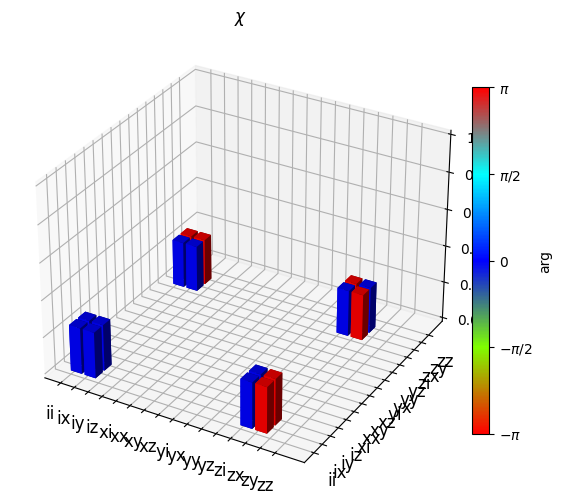

In [19]:
fig = plt.figure(figsize=(12,6))

U_i_s = to_super(U)

chi = qpt(U_i_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## cnot gate calculated using GRAPE

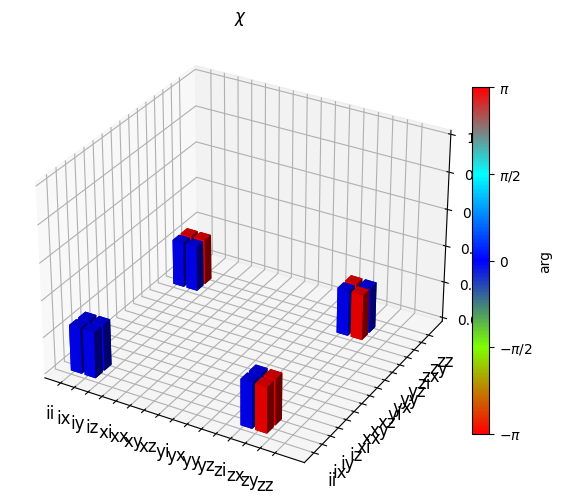

In [20]:
fig = plt.figure(figsize=(12,6))

U_f_s = to_super(result.U_f)

chi = qpt(U_f_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [21]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.7.1.dev0+ff9ada8
Numpy,1.24.0
SciPy,1.9.3
matplotlib,3.6.2
Cython,0.29.32
Number of CPUs,8
BLAS Info,OPENBLAS
IPython,8.7.0
Python,"3.11.0 (v3.11.0:deaf509e8f, Oct 24 2022, 14:43:23) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
